<a href="https://colab.research.google.com/github/dixitritik17/Plant-Disease-Detection-and-Solution-using-Deep-learning/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Disease Detection and Solution using Deep learning**

### **1. Importing Libraries**

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

### **2. Download Dataset**

In [ ]:
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip 
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:04, 203MB/s]
replace PlantVillage/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **3. Loading Dataset**

In [ ]:
DEFAULT_IMG_SZ = tuple((256, 256))

N_IMG = 90

root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMG_SZ)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []

try:
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMG]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("Image loading done")  
except Exception as e:
    print(f"Error : {e}")

# Transform training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Number of loaded images
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Peach___healthy ...
[INFO] Processing background ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Pro

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Number of classes: ", n_classes)

Number of classes:  39


### **Augmentation and Splitting of Dataset**

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [ ]:
print("Dividing data to train and test sets")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

Dividing data to train and test sets


### **Model** **Architecture**

In [ ]:
EPOCHS = 45
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [ ]:
model = Sequential()
inputSize = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", activation="relu",input_shape=inputSize))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0

### **Training the model**

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=LR, decay=LR / EPOCHS), metrics=["accuracy"])

print("Model being trained")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

Model being trained
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/45
87/87 [==============================] - 379s 4s/step - loss: 0.1037 - accuracy: 0.2759 - val_loss: 0.3460 - val_accuracy: 0.0399
Epoch 2/45
87/87 [==============================] - 381s 4s/step - loss: 0.0782 - accuracy: 0.4269 - val_loss: 0.3671 - val_accuracy: 0.0427
Epoch 3/45
87/87 [==============================] - 379s 4s/step - loss: 0.0698 - accuracy: 0.4816 - val_loss: 0.3299 - val_accuracy: 0.0356
Epoch 4/45
87/87 [==============================] - 376s 4s/step - loss: 0.0640 - accuracy: 0.5360 - val_loss: 0.2729 - val_accuracy: 0.0855
Epoch 5/45
87/87 [==============================] - 374s 4s/step - loss: 0.0556 - accuracy: 0.5868 - val_loss: 0.2408 - val_accuracy: 0.1368
Epoch 6/45
87/87 [==============================] - 373s 4s/step - loss: 0.0503 - accuracy: 0.6279 - val_loss: 0.1471 - val_accuracy: 0.2692
Epoch 7/45
87/87 [==============================] - 375s 4

### **Visualizing the model**

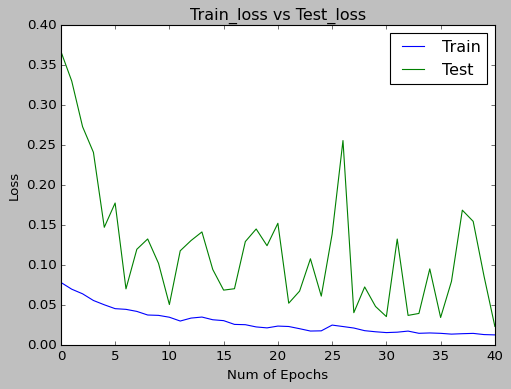

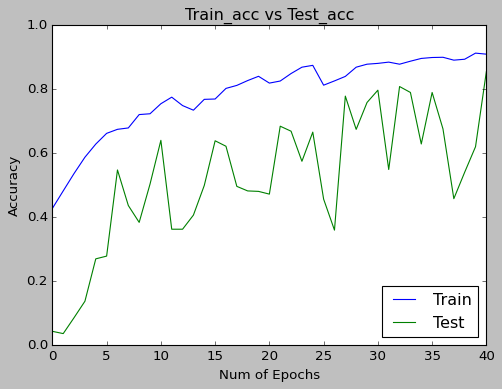

In [ ]:
train_acc=history.history['accuracy']
train_acc=train_acc[1:42]
test_acc=history.history['val_accuracy']
test_acc=test_acc[1:42]
train_error=history.history['loss']
train_error=train_error[1:42]
test_error=history.history['val_loss']
test_error=test_error[1:42]
xc=range(41)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_error)
plt.plot(xc,test_error)
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.title('Train_loss vs Test_loss')
plt.legend(['Train','Test'])
plt.style.use(['fast'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,test_acc)
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.title('Train_acc vs Test_acc')
plt.legend(['Train','Test'],loc=4)
plt.style.use(['classic'])

In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [ ]:
def predictD(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    t=image_labels.classes_[result][0]
    print((t))
    if t=="Soybean___healthy" or t=="Tomato___healthy" or t=="Peach___healthy" or t=="Corn_(maize)___healthy" or t=="Cherry_(including_sour)___healthy" or t=="Potato___healthy" or t=="Strawberry___healthy" or t=="Apple___healthy" or t=="Raspberry___healthy" or t=="Grape___healthy" or t=="Blueberry___healthy" or t=="Pepper,_bell___healthy":
      print("The Plant is healthy...")
    elif t=="Cherry_(including_sour)___Powdery_mildew":
      print("Treatment: ")
      print("1. Fungicides can be applied as the disease develops.")
      print("2. Cultural practices such as pruning orchard trees and removing hedgerows located close to the") 
      print("orchard aid in the drying of foliage and fruit and help control this disease.")
    elif t=="Corn_(maize)___Northern_Leaf_Blight":
      print("Treatment: ")
      print("1. A combination of crop rotation for one to two years followed by tillage is recommended to prevent NCLB disease development.")
      print("2. The use of foliar fungicides for corn have also been shown to control NCLB. ") 
    elif t=="Tomato___Target_Spot":
      print("Treatment: ")
      print("1. Do not plant new crops next to older ones that have the disease.")
      print("2. Plant as far as possible from papaya, especially if leaves have small angular spots ")
      print("3. Check all seedlings in the nursery, and throw away any with leaf spots.") 
    elif t=="Potato___Early_blight":
      print("Treatment: ")
      print("1.Treatment of early blight includes prevention by planting potato varieties that are resistant to the disease; late maturing are more resistant than early maturing varieties.")
    elif t=="Pepper,_bell___Bacterial_spot":
      print("Treatment: ")
      print("1. Use disease-free seed that has been produced in western states or seed that has been hot water treated. One infested seed in 10,000 may easily result in 100% diseased plants in the field under proper conditions.")
      print("2. Practice crop rotation. Use at least 1-year rotation between tomato or pepper crops with nonhost crops. ") 
    elif t=="Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot":
      print("Treatment: ")
      print("1. Crop rotation")
      print("2. Residue management ") 
      print("3. Fungicides")
    elif t=="Squash___Powdery_mildew":
      print("Treatement by using: ")
      print("1. Baking Soda")
      print("2. Potassium bicarbonate")
      print("3. Mouthwash ")
      print("4. Vinegar")
      print("5. Milk or Water")
    elif t=="Potato___Late_blight":
      print("Treatement: ")
      print("1. Pull the Late Blight Infected Plant")
      print("2. Prevent Overwintering")
    elif t=="Tomato___Tomato_Yellow_Leaf_Curl_Virus":
      print("Treatement: ")
      print("Treatments include insecticides, hybrid seeds, and growing tomatoes under greenhouse conditions.")
    elif t=="Grape___Esca_(Black_Measles)":
      print("Treatement: ")
      print("Presently, there are no effective management strategies for measles.")
      print("Wine grape growers with small vineyards will often have field crews ")
      print("remove infected fruit prior to harvest.")
      print("Raisins affected by measles will be discarded during harvest or at ")
      print("the packing house, while table grape growers will leave affected fruit on the vine. ")
    elif t=="Grape___Leaf_blight_(Isariopsis_Leaf_Spot)":
      print("Treatement: ")
      print("Fungicides sprayed for other diseases in the season may help to reduce this disease.")
    elif t=="Corn_(maize)___Common_rust_":
      print("Treatement: ")
      print("1. Apply a foliar fungicide ")
    elif t=="Apple___Apple_scab":
      print("Treatement: ")
      print("Fungicides can be used to manage apple scab. Proper timing of sprays is needed for fungicides to control disease.")
    elif t=="Orange___Haunglongbing_(Citrus_greening)":
      print("Treatement: ")
      print("1. Certain antibiotics, specifically streptomycin and oxytetracycline, ")
      print("may be effective in the fight against citrus greening disease.")
    elif t=="Tomato___Early_blight":
      print("Treatement: ")
      print("1. Tomatoes that have early blight require immediate attention before the disease takes over the plants. ")
      print("2. Thoroughly spray the plant (bottoms of leaves also) with Bonide Liquid Copper Fungicide concentrate or Bonide Tomato & Vegetable.")
    elif t=="Strawberry___Leaf_scorch":
      print("Treatement: ")
      print("Removal of infected garden debris from the strawberry patch, as well as the frequent establishment of new strawberry transplants.")
    elif t=="Grape___Black_rot":
      print("Treatement: ")
      print(" Mancozeb, and Ziram are all highly effective against black rot.")
    elif t=="Tomato___Leaf_Mold":
      print("Treatement: ")
      print("Applying fungicides when symptoms first appear can reduce the spread of the leaf mold fungus significantly.")
    elif t=="Tomato___Tomato_mosaic_virus":
      print("Treatement: ")
      print("There are no cures for viral diseases such as mosaic once a plant is infected. ")
      print("As a result, every effort should be made to prevent the disease from entering your garden.")
    elif t=="Tomato___Septoria_leaf_spot":
      print("Treatement: ")
      print("1. Removing infected leaves")
      print("2. Consider organic fungicide options.")
      print("3. Consider chemical fungicides.")
    elif t=="Tomato___Bacterial_spot":
      print("Treatement: ")
      print("A plant with bacterial spot cannot be cured. Remove symptomatic plants from the field or greenhouse to prevent the spread of bacteria to healthy plants.")
    elif t=="Apple___Black_rot":
      print("Treatement: ")
      print("Captan and sulfur products are labeled for control of black rot")
    elif t=="Apple___Cedar_apple_rust":
      print("Treatement: ")
      print("Apply preventative, disease-fighting fungicides labeled for use on apples weekly, starting with bud break, to protect trees from spores being released by the juniper host")
    elif t=="Peach___Bacterial_spot":
      print("Treatement: ")
      print("Compounds available for use on peach and nectarine for bacterial spot include copper, ")
      print("oxytetracycline (Mycoshield and generic equivalents), and syllit+captan")
    elif t=="Tomato___Spider_mites Two-spotted_spider_mite":
      print("Treatement: ")
      print("1. Avoid weedy fields and do not plant eggplant adjacent to legume forage crops.")
      print("2. Overhead irrigation or prolonged periods of rain can help reduce populations.")
    elif t=="Tomato___Late_blight":
      print("Use fungicide sprays based on mandipropamid, chlorothalonil, fluazinam, mancozeb to combat late blight. ")


Corn_(maize)___healthy
The Plant is healthy...


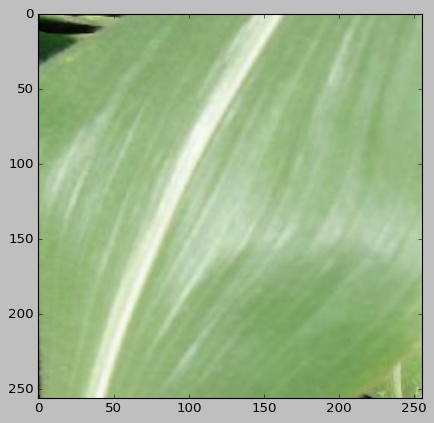

In [ ]:
predictD('/content/PlantVillage/val/Corn_(maize)___healthy/068794e5-0a99-405f-bbb9-1f954e11942d___R.S_HL 7909 copy 2.jpg')

Cherry_(including_sour)___Powdery_mildew
Treatment: 
1. Fungicides can be applied as the disease develops.
2. Cultural practices such as pruning orchard trees and removing hedgerows located close to the
orchard aid in the drying of foliage and fruit and help control this disease.


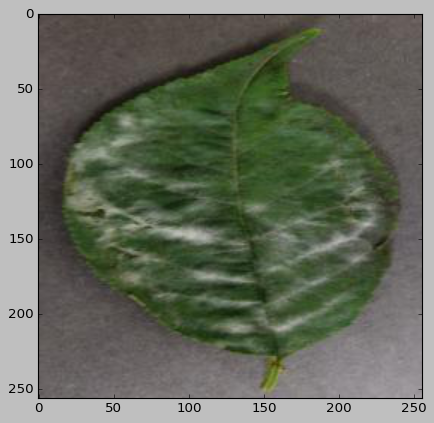

In [ ]:
predictD('/content/PlantVillage/val/Cherry_(including_sour)___Powdery_mildew/012b55cf-de7a-483a-9118-0fd8ff012185___FREC_Pwd.M 0423.JPG')

Grape___Esca_(Black_Measles)
Treatement: 
Presently, there are no effective management strategies for measles.
Wine grape growers with small vineyards will often have field crews 
remove infected fruit prior to harvest.
Raisins affected by measles will be discarded during harvest or at 
the packing house, while table grape growers will leave affected fruit on the vine. 


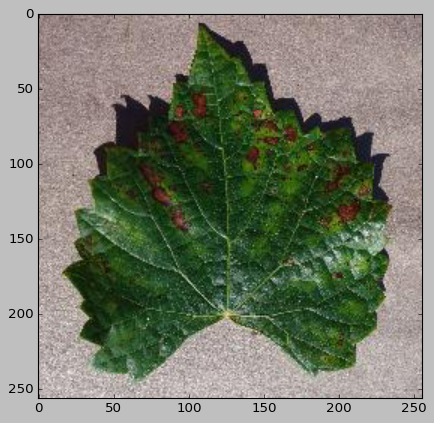

In [ ]:
predictD('/content/PlantVillage/val/Grape___Esca_(Black_Measles)/04e2f4d2-ee75-4043-accc-307c6c7f2af0___FAM_B.Msls 1035.JPG')

Squash___Powdery_mildew
Treatement by using: 
1. Baking Soda
2. Potassium bicarbonate
3. Mouthwash 
4. Vinegar
5. Milk or Water


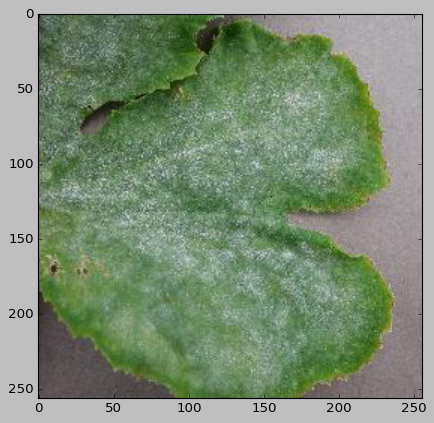

In [ ]:
predictD('/content/PlantVillage/val/Squash___Powdery_mildew/009996d9-797e-4450-afad-e8346f7ede04___UMD_Powd.M 0216.JPG')